# Extract Data from Dataset.zip

In [1]:
import zipfile
import os

# Path to the dataset zip file
zip_file_path = '/content/drive/MyDrive/Dataset.zip'
extract_dir = 'path/to/extracted_data/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define paths for the extracted content
train_images_dir = os.path.join(extract_dir, 'images/train_images')
test_images_dir = os.path.join(extract_dir, 'images/test_images')
train_csv_path = os.path.join(extract_dir, 'training.csv')

# Load and Preprocess the Images

In [2]:
from PIL import Image
import numpy as np
import pandas as pd

# Function to load images
def load_images(image_folder):
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = Image.open(os.path.join(image_folder, filename)).convert('L') # Convert to grayscale
            images.append(np.array(img))
    return np.array(images)

train_images = load_images(train_images_dir)
test_images = load_images(test_images_dir)

In [3]:
def preprocess_images(images, target_size=(96, 96)):
    processed_images = []
    for img in images:
        img = Image.fromarray(img).resize(target_size) # Resize image
        img = np.array(img) / 255.0 # Normalize image
        processed_images.append(img.reshape(target_size + (1,))) # Add channel dimension
    return np.array(processed_images)

processed_train_images = preprocess_images(train_images)
processed_test_images = preprocess_images(test_images)
processed_train_images.shape, processed_test_images.shape

((7049, 96, 96, 1), (1783, 96, 96, 1))

# Load and Preprocess the CSV File

In [4]:
# Load the keypoints CSV file
keypoints_df = pd.read_csv(train_csv_path)

In [5]:
# Function to normalize keypoints
def normalize_keypoints(keypoints_df):
    keypoints = keypoints_df.values
    keypoints = keypoints / 96.0 # Assuming original images are 96x96
    return keypoints

normalized_keypoints = normalize_keypoints(keypoints_df)
print(normalized_keypoints)

[[0.68784962 0.40627368 0.31486466 ... 0.75974436 0.4492782  0.88006015]
 [0.67013475 0.36427163 0.31197163 ... 0.73194326 0.47362411 0.89041844]
 [0.67767763 0.36364211 0.32191447 ... 0.73116447 0.49244737 0.81936842]
 ...
 [0.69469512 0.38380439 0.32985854 ...        nan 0.51523512 0.81372   ]
 [0.73921961 0.41514235 0.31815922 ...        nan 0.52151235 0.82902549]
 [0.69727407 0.45233864 0.32391728 ...        nan 0.47813    0.86221975]]


In [6]:
# Check for NaN values in the keypoints
print(np.isnan(normalized_keypoints).sum())

# Optionally fill NaN values with 0 or mean
normalized_keypoints = np.nan_to_num(normalized_keypoints, nan=0.0)

105412


In [7]:
print(np.isnan(normalized_keypoints).sum())

0


# Split the Dataset

In [8]:
from sklearn.model_selection import train_test_split

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(processed_train_images, normalized_keypoints, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
X_train.shape

(5639, 96, 96, 1)

In [10]:
X_val.shape

(705, 96, 96, 1)

# Define the CNN Model

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(30) # 15 keypoints with (x, y) coordinates
    ])
    return model

model = create_cnn_model((96, 96, 1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the Model

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
177/177 [==============================] - 10s 18ms/step - loss: 0.0539 - mae: 0.1806 - val_loss: 0.0449 - val_mae: 0.1731
Epoch 2/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0444 - mae: 0.1630 - val_loss: 0.0405 - val_mae: 0.1537
Epoch 3/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0423 - mae: 0.1568 - val_loss: 0.0403 - val_mae: 0.1458
Epoch 4/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0406 - mae: 0.1509 - val_loss: 0.0402 - val_mae: 0.1496
Epoch 5/50
177/177 [==============================] - 2s 12ms/step - loss: 0.0388 - mae: 0.1459 - val_loss: 0.0398 - val_mae: 0.1483
Epoch 6/50
177/177 [==============================] - 2s 13ms/step - loss: 0.0374 - mae: 0.1412 - val_loss: 0.0408 - val_mae: 0.1460
Epoch 7/50
177/177 [==============================] - 2s 14ms/step - loss: 0.0361 - mae: 0.1377 - val_loss: 0.0404 - val_mae: 0.1339
Epoch 8/50
177/177 [==============================] - 2s 12ms/step -

# Model Evaluation

1/1 [==============================] - 0s 93ms/step


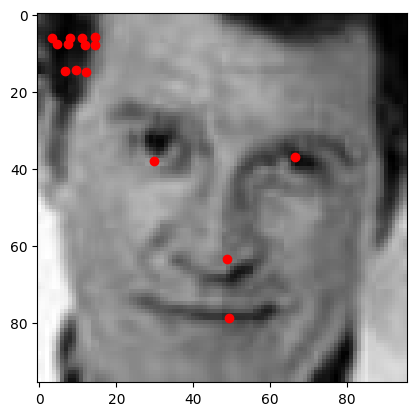

In [13]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)

# Visualize the model's predictions
import matplotlib.pyplot as plt

def plot_keypoints(image, keypoints):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.scatter(keypoints[::2] * 96, keypoints[1::2] * 96, c='red')
    plt.show()

# Predict keypoints on a sample test image
sample_image = X_test[0]
predicted_keypoints = model.predict(np.expand_dims(sample_image, axis=0))[0]
plot_keypoints(sample_image, predicted_keypoints)

# Hyperparameter Tuning and Data Augmentation

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=50)

Epoch 1/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0416 - mae: 0.1487 - val_loss: 0.0394 - val_mae: 0.1435
Epoch 2/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0407 - mae: 0.1477 - val_loss: 0.0391 - val_mae: 0.1412
Epoch 3/50
177/177 [==============================] - 8s 43ms/step - loss: 0.0402 - mae: 0.1461 - val_loss: 0.0389 - val_mae: 0.1407
Epoch 4/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0403 - mae: 0.1463 - val_loss: 0.0411 - val_mae: 0.1503
Epoch 5/50
177/177 [==============================] - 8s 43ms/step - loss: 0.0392 - mae: 0.1442 - val_loss: 0.0415 - val_mae: 0.1479
Epoch 6/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0393 - mae: 0.1433 - val_loss: 0.0392 - val_mae: 0.1481
Epoch 7/50
177/177 [==============================] - 7s 42ms/step - loss: 0.0390 - mae: 0.1433 - val_loss: 0.0385 - val_mae: 0.1431
Epoch 8/50
177/177 [==============================] - 6s 33ms/step - 

# Train the model with callbacks

In [15]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model with data augmentation and callbacks
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint])

Epoch 1/50
177/177 [==============================] - 8s 43ms/step - loss: 0.0350 - mae: 0.1306 - val_loss: 0.0391 - val_mae: 0.1315 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/177 [==============================] - 6s 33ms/step - loss: 0.0353 - mae: 0.1311 - val_loss: 0.0400 - val_mae: 0.1387 - lr: 0.0010
Epoch 3/50
177/177 [==============================] - 8s 44ms/step - loss: 0.0350 - mae: 0.1308 - val_loss: 0.0385 - val_mae: 0.1395 - lr: 0.0010
Epoch 4/50
177/177 [==============================] - 6s 34ms/step - loss: 0.0348 - mae: 0.1304 - val_loss: 0.0383 - val_mae: 0.1365 - lr: 0.0010
Epoch 5/50
177/177 [==============================] - 7s 42ms/step - loss: 0.0349 - mae: 0.1309 - val_loss: 0.0415 - val_mae: 0.1433 - lr: 0.0010
Epoch 6/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0350 - mae: 0.1305 - val_loss: 0.0391 - val_mae: 0.1388 - lr: 0.0010
Epoch 7/50
177/177 [==============================] - 8s 43ms/step - loss: 0.0343 - mae: 0.1291 - val_loss: 0.0411 - val_mae: 0.1402 - lr: 0.0010
Epoch 8/50
177/177 [==============================] - 6s 33ms/step - loss: 0.0344 - mae: 0.1286 - val_loss: 0.0384 - val_mae: 0.1382 - 

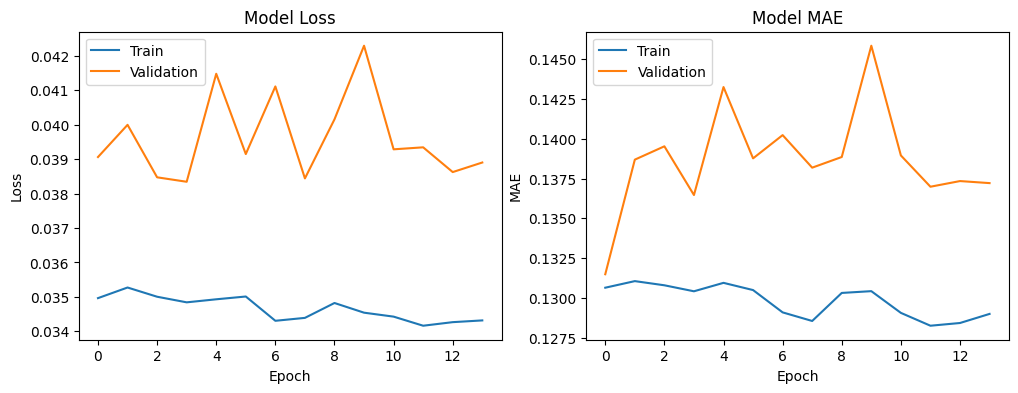

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()